In [1]:
%run ../widgets/config_check.py

sys:1: UserWarning: Your current version of bqplot (0.10.5) is older then the one used in tests (0.11). It is recommended to uprgade it.


In [2]:
# <api>
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.special import logsumexp
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook
smpl_intro = load_notebook('./Sampling_Intro.ipynb')
smpl_rej = load_notebook('./Sampling_Rejection.ipynb')

import os
path = os.getcwd()
s = '/'
pardir = s.join(path.split(s)[:-1])
# Load widgets
smpl_widgets = load_notebook(str(pardir + '/widgets/2D_sampling_widget.ipynb'))

# Slice Sampling

Slice sampling is an example of an auxiliary variable method. In this case, the state space is enlarged to $x, u$ and sampling from a target distribution $p(x,u)$ instead. To obtain samples from $p(x)$ the $u$-component can simpy be dropped as
$$ \mathbb{E}_p[f] = \int f(x) p(x) dx = \int \int f(x) p(x,u) dx du \approx \frac{1}{N} \sum_{i=1}^N f(x_i) $$

Slice sampling aims to sample uniformly from the region below $p(x)$, i.e. $p(x,u) = Uniform(\{x,u: 0 < u < p(x)\})$. It does this by interleaving two Gibbs steps:

1. Sample $u \sim p(u|x) = Uniform(0, p(x))$
2. Sample $x \sim p(x|u) = Uniform(\{x : u < p(x)\})$

The second step requires a method to sample uniformly from the so called *slice*, i.e. the set of all $x$ with probability at least $u$. In high-dimensional spaces this is often infeasible and slice sampling is usually formulated for a 1-dimensional $x$. In this case, the slice can be obtain by an adaptive procedure which expands and shrinks a range around the current sample. In this sense, slice sampling can be considered as a Metropolis-Hastings sampling which adapts its proposal distribution to the width of the probable region.

**Exercise:** Show that the slice adjustment in the algorithm below leaves the uniform target density invariant.

In [3]:
# <api>
class SliceSampling (smpl_intro.Sampling):
    def __init__ (self, log_p, x, w):
        self.log_p = log_p
        self.x = x
        self.w = w
        self.samples = 0
        self.evals = 0
        
    def _log_p (self, x):
        self.evals += 1
        return self.log_p(x)
    
    def sample (self):
        self.samples += 1
        # Slice sampling as in MacKay pp. 375
        log_px = self._log_p(self.x)
        log_u_prime = np.log(np.random.uniform(low=0, high=np.exp(log_px)))
        # Create interval
        r = np.random.uniform()
        xl = self.x - r*self.w
        xr = self.x + (1-r)*self.w
        while (self._log_p(xl) > log_u_prime): 
            xl -= self.w
        while (self._log_p(xr) > log_u_prime):
            xr += self.w
        # Main sampling loop
        while True:
            x_prime = np.random.uniform(low=xl, high=xr)
            log_px_prime = self._log_p(x_prime)
            if log_px_prime > log_u_prime:
                self.x = x_prime
                return x_prime # Found new sample
            else:
                # Adjust interval
                if x_prime > self.x:
                    xr = x_prime
                else:
                    xl = x_prime
        
    def __str__ (self):
        return "Slice sampling: %d evaluations for %d samples" % (self.evals, self.samples)

In [4]:
sampling = SliceSampling(log_p=lambda x: np.log(smpl_rej.p(x)), x=-3.0, w=1.5)

smpl_intro.show_sampling(sampling, plotter=smpl_intro.gauss_hist, N=1000)
print(sampling)

Output()

Slice sampling: 6601 evaluations for 1000 samples


Slice sampling can be applied to multivariate distributions by sampling in different 1-dimensional directions. Most often the directions are just chosen as the coordinate axis and, similar to Gibbs sampling, all coordinates are sampled in sequence.

Here, we apply this scheme to the 2-dimensional Gaussian example:

In [5]:
# <api>
class MultiSampling (smpl_intro.Sampling):
    """
    Class that wraps a one-dimensional sampler and applies it to 
    a sequence of given directions to produce a new sample
    """
    def __init__(self, uni_sampler, log_p, x, directions):
        """
        uni_sampler is called with a log_p function and current sample x.
        It needs to return a valid sampler which is then asked to draw a sample.
        """
        self.uni_sampler = uni_sampler
        self.log_p = log_p
        self.x = x
        self.directions = directions
        
    def sample (self):
        # Loop through directions
        for d in self.directions:
            uni_log_p = lambda ux: self.log_p(self.x + ux*d)
            ux_prime = self.uni_sampler(uni_log_p, 0).sample()
            self.x = self.x + ux_prime*d
        return self.x

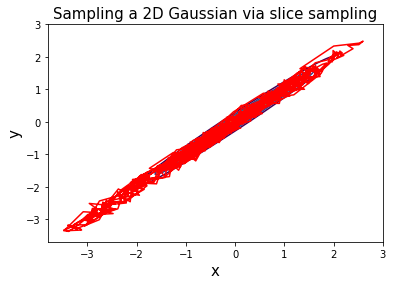

In [6]:
sampling = MultiSampling(lambda log_p, x: SliceSampling(log_p, x, w=1.0), \
                         log_p=smpl_rej.p2d.logpdf, \
                         x=np.array([1.5,0]), \
                         directions=[np.array([1,0]), np.array([0,1])])
samples = [sampling.sample() for _ in range(1000)]
plt.plot(np.array(samples)[:,0], np.array(samples)[:,1], 'r-')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Sampling a 2D Gaussian via slice sampling', fontsize=15)
plt.contour(smpl_rej.X, smpl_rej.Y, smpl_rej.p2d.pdf(smpl_rej.XY));

By choosing the sampling directions more cleverly, we can substantially reduce the random walk behavior and improve the efficiency of sampling from the 2-dimensional Gaussian.

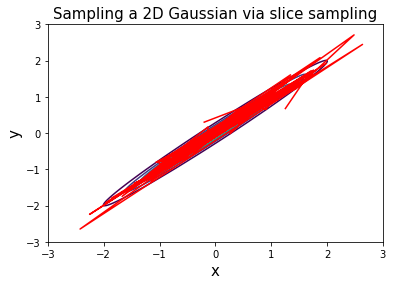

In [7]:
sampling = MultiSampling(lambda log_p, x: SliceSampling(log_p, x, w=1.0), \
                         log_p=smpl_rej.p2d.logpdf, \
                         x=np.array([1.5,0]), \
                         directions=[np.array([1,1]), np.array([1,-1])])
samples = [sampling.sample() for _ in range(100)]
plt.plot(np.array(samples)[:,0], np.array(samples)[:,1], 'r-')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Sampling a 2D Gaussian via slice sampling', fontsize=15)
plt.contour(smpl_rej.X, smpl_rej.Y, smpl_rej.p2d.pdf(smpl_rej.XY));

In [8]:
widget = smpl_widgets.SamplingWidget(method='MSSD', target='MN')
widget.show()